In [57]:
from healpy import sphtfunc, visufunc, fitsfunc
from pixell import curvedsky, enmap, enplot, utils
import importlib
import numpy as np
import matplotlib.pyplot as plt
import path
import load_data
import noise_model
import ipdb
import reconstruction_noise
from pixell import curvedsky, enmap, enplot, utils, lensing
import plot_ps
from astropy.io import fits
import os
importlib.reload(plot_ps)

<module 'plot_ps' from '/home/ketchup/Dropbox/cosmology/lensing/newlens/plot_ps.py'>

In [58]:
nside = 600
lmax = 1000
lmin = 2
ls = np.arange(0, lmax + 1)
nlev_t = 1.  # telmperature noise level, in uk.arclmin
nlev_p = np.sqrt(2)*nlev_t
bealm_fwhlm = 2.

noise = noise_model.noise(bealm_fwhlm, lmax, nlev_t, nlev_p)
nltt = noise.tt()
nlee = noise.ee()
nlbb = noise.bb()

In [59]:
class rec_TT:
    """ using TT estimator to reconstruct phi_lm and phi_cl using healpy """

    def __init__(self, *args):
        """input spectra"""
        self.lmin = args[0]
        self.lmax = args[1]
        self.nside = args[2]
        
        self.ul_cl = load_data.unlensed(self.lmin, self.lmax, 'TT').spectra()
        
        self.alm = fitsfunc.read_alm('obs_lm.fits')
        self.obs_cl = sphtfunc.alm2cl(self.alm)
        self.norm = reconstruction_noise.TT(self.lmin, self.lmax, bealm_fwhlm,
                                            nlev_t, nlev_p).noise()
    def factor(self):
        ell = np.arange(self.lmin, self.lmax + 1)
        return ell * (ell + 1)
    
    def weight(self):
        ell = np.arange(self.lmin, self.lmax + 1)

        cl1 = 1 / self.obs_cl[ell]
        alm1 = sphtfunc.almxfl(self.alm, cl1)
        map1 = sphtfunc.alm2map(alm1, self.nside)

        cl2 = self.ul_cl[ell] / self.obs_cl[ell]
        alm2 = sphtfunc.almxfl(self.alm, cl2)
        map2 = sphtfunc.alm2map(alm2, self.nside)

        ret_lm = sphtfunc.almxfl(
            sphtfunc.map2alm(map1 * map2, lmax=self.lmax), 1/2 * self.factor())
        return ret_lm

    
    def d_lm(self):
        ell = np.arange(self.lmin, self.lmax + 1)
        ret_alm = sphtfunc.almxfl(self.weight(), self.norm[ell]/(np.sqrt(self.factor())))
        return ret_alm

    def cl_dd(self):
        ell = np.arange(self.lmin, self.lmax + 1)
        return sphtfunc.alm2cl(self.d_lm())


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


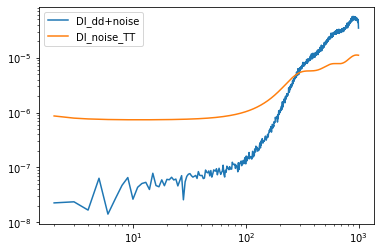

In [66]:
Rec_TT = rec_TT(lmin, lmax, nside)
Dl_dd = (ls*(ls+1))[lmin:lmax-1]*Rec_TT.cl_dd()[lmin:lmax-1]/(2*np.pi)
Dl_noise_TT = (ls*(ls+1))[lmin:lmax-1]*reconstruction_noise.TT(lmin, lmax, bealm_fwhlm,
                                            nlev_t, nlev_p).noise()[lmin:lmax-1]/(2*np.pi)
Dl_noise_EB = (ls*(ls+1))[lmin:lmax-1]*reconstruction_noise.EB(lmin, lmax, bealm_fwhlm, nlev_t, nlev_p).noise()[lmin:lmax-1]/(2*np.pi)

plt.plot(ls[lmin:lmax-1], Dl_dd)
#plt.plot(ls[lmin:lmax-1], Dl_noise_EB)
plt.plot(ls[lmin:lmax-1], Dl_noise_TT)
plt.xscale('log')
plt.yscale('log')
plt.legend(['Dl_dd+noise','Dl_noise_TT'])
plt.show()

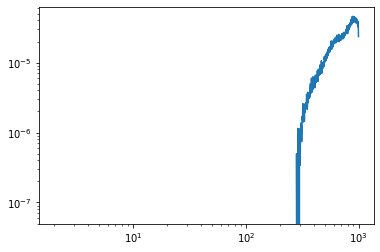

In [64]:
plt.plot(ls[lmin:lmax-1], Dl_dd - Dl_noise_TT)
plt.xscale('log')
plt.yscale('log')
plt.show()